## Business Problem Understanding

**Context**  
Sebuah perusahaan penyedia layanan telekomunikasi memiliki jumlah customer yang tergolong banyak, dimana terdapat customer yang masih berlangganan dan sudah berhenti berlangganan.Perusahaan ingin mengetahui customer mana yang ingin berhenti berlangganan agar dapat membantu mencegah menurunnya pendapatan perusahaan, membantu perusahaan dalam memberikan penawaran menarik yang lebih efektif, dan membantu perusahaan dalam meningkatkan layanannya.  
  
Target :

0 : Masih Berlangganan

1 : Berhenti Berlangganan

**Problem Statement**  
Banyaknya customer yang berhenti berlangganan tentunya akan berdampak pada penurunan pendapatan yang diterima perusahaan, jika tidak ditangani segera maka dapat menghambat pertumbuhan perusahaan, dan bahkan dapat berujung pada kebangkrutan perusahaan karena semakin banyak customer yang berhenti berlangganan.

**Goals**  
Perusahaan ingin mampu memprediksi customer yang berpotensi untuk berhenti berlangganan, sehingga perusahaan dapat mencegah customer tersebut dari keputusan untuk berhenti berlangganan.Perusahaan juga ingin tahu faktor-faktor yang mendorong customer untuk berhenti berlangganan ataupun tetap berlangganan.Dengan demikian perusahaan dapat menyusun rencana yang lebih matang dan efektif dalam mengatasi masalah tersebut.

**Analytic Approach**  
* Pertama kita akan melakukan analisis pada features dataset kita untuk menemukan pola yang membedakan antara customer yang berhenti dan yang masih berlangganan.
* Setelah itu kita akan membangun model klasifikasi untuk membantu perusahaan yang mampu memprediksi probabilitas customer yang akan berhenti berlangganan atau tidak.

**Metric Evaluation**  
* Type I Error : False Positive  
Konsekuensi : Cost yang dikeluarkan untuk mempertahankan customer untuk tetap berlangganan seperti diskon atau promo khusus kurang efisien.
* Type II Error : False Negative  
Konsekuensi : Penurunan pendapatan perusahaan.  
  
Berdasarkan kedua konsekuensi, konsekuensi type I error mengakibatkan perusahaan mengeluarkan biaya yang kurang efisien, namun jika dipikirkan baik-baik biaya tersebut tidak seluruhnya menjadi sia-sia, karena dengan biaya yang dikeluarkan seperti diskon khusus untuk pelanggan yang diprediksi akan berhenti tetapi sebenarnya tidak, diskon ini justru bisa membantu menjaga agar customer tidak mencoba/setidaknya mempertimbangkan untuk berlangganan di perusahaan kompetitor lainnya. Sedangkan konsekuensi dari type II error, penurunan pendapatan akibat customer yang berhenti berlangganan tentunya sangat penting dan harus diatasi terutama customer yang memiliki value tinggi, dan juga untuk menutup loss akibat customer yang berhenti karena tidak terprediksi maka perusahaan memerlukan customer baru untuk hanya menutup loss saja, untuk memperoleh customer baru perusahaan juga harus mengeluarkan biaya lagi untuk promosi,iklan,kampanye,dll sehingga cost dari error ini harus sebisa mungkin diminimalisir.Jadi untuk model ini kita ingin memprediksi sebanyak mungkin kelas positif yang benar dari total kelas positif yang ada dan meminimalisir prediksi kelas negatif yang sebenarnya adalah positif, sehingga metric utama yang akan digunakan adalah recall.
  
* Cost untuk mendapatkan pengguna baru bisa lebih besar hingga 5x atau lebih dibanding cost untuk mempertahankan pelanggan berdasarkan [https://www.academia.edu/10217411/Do_Customer_Acquisition_Cost_Retention_and_Usage_Matter_to_Firm_Performance_and_Valuation]

# 

## Data Understanding

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import numpy as np
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,recall_score,f1_score,classification_report,precision_score,roc_auc_score
from imblearn.over_sampling import SMOTENC,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import time
import dill

**Data Dictionary**
* Dependents: Whether the customer has dependents or not.(Parent,kids,etc)
* Tenure: Number of months the customer has stayed with the company.
* OnlineSecurity: Whether the customer has online security or not.
* OnlineBackup: Whether the customer has online backup or not.
* InternetService: Whether the client is subscribed to Internet service.
* DeviceProtection: Whether the client has device protection or not.
* TechSupport: Whether the client has tech support or not 
* Contract: Type of contract according to duration.
* PaperlessBilling: Bills issued in paperless form.
* MonthlyCharges: Amount of charge for service on monthly bases.
* Churn: Whether the customer churns or not.(**Target**)

In [4]:
# Tampilan 10 baris data teratas
df = pd.read_csv('D:\Purwadhika\Modul 3\Modul 3\Capstone Modul 3\data_telco_customer_churn.csv')
df.head(10)

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
5,Yes,40,No,No,DSL,Yes,No,Month-to-month,Yes,74.55,No
6,No,17,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.70,No
7,No,11,No,No,DSL,No,No,Month-to-month,Yes,44.05,Yes
8,No,8,No,No,Fiber optic,No,No,Month-to-month,Yes,73.50,No
9,Yes,47,Yes,No,DSL,Yes,Yes,One year,No,40.30,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


## Data Cleaning

* Di sini kita bisa melihat dataset kita tidak memiliki missing value pada setiap kolomnya.

In [5]:
display(df.describe(),df.describe(include='O')) 

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


In [6]:
pd.melt(df,value_vars=df.columns).groupby('variable')['value'].agg(n_unique=lambda x:x.nunique(),
                                                                            unique_value=lambda x:x.unique()).reset_index()

,variable,n_unique,unique_value
0,Churn,2,"[Yes, No]"
1,Contract,3,"[Month-to-month, Two year, One year]"
2,Dependents,2,"[Yes, No]"
3,DeviceProtection,3,"[Yes, No internet service, No]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."
6,OnlineBackup,3,"[No, Yes, No internet service]"
7,OnlineSecurity,3,"[No, Yes, No internet service]"
8,PaperlessBilling,2,"[Yes, No]"
9,TechSupport,3,"[Yes, No, No internet service]"


* Pada kolom tenure terdapat nilai minimum yaitu 0, jika dilihat dari dictionary ini bisa saja terjadi pada kustomer baru yang belum genap sebulan bergabung jadi data ini bukanlah sebuah anomali.

* Pada beberapa kolom seperti DeviceProtection,OnlineBackup,OnlineSecurity, dan TechSupport terdapat kategori 'No internet service'.Setelah ditelusuri lebih lanjut, saya menemukan deskripsi lengkap dataset kita dari sumber aslinya [https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113].Ternyata kolom yang kita sebutkan merupakan layanan yang bersifat online, maka dari itu 'No internet service' nantinya mungkin bisa kita coba gabungkan pada saat modeling dengan kategori 'No' pada tiap kolomnya.

### Missing Values

In [7]:
print(df.isna().sum())
print(f'\nTotal missing value : {df.isna().sum().sum()}')

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

Total missing value : 0


Pada dataset ini tidak terdapat missing value.

### Duplicate Data

In [5]:
print(f'Jumlah data duplikat : {df.duplicated().sum()}')

Jumlah data duplikat : 77


In [6]:
df[df.duplicated()]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
624,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
701,No,41,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.65,No
786,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.65,Yes
951,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.15,Yes
1266,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
...,...,...,...,...,...,...,...,...,...,...,...
4759,No,4,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.05,No
4786,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
4788,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,70.10,Yes
4866,No,1,No,No,DSL,No,No,Month-to-month,Yes,55.00,Yes


* Di sini kita menemukan adanya data yang duplikat sebanyak 77 baris.
* Dari data yang tersedia kita tidak dapat secara pasti menentukan apakah data duplikat ini merupakan suatu kesalahan input atau data sebenarnya yang kebetulan sama.
* Maka dari itu sebaiknya data tersebut dihapus saja, karena dalam membangun model machine learning data duplikat ini dapat memiliki pengaruh negatif pada model kita nantinya seperti model yang bias, overfitting, redundant.[https://www.linkedin.com/advice/1/what-best-way-handle-duplicate-data-dataset-ml-models#:~:text=Duplicate%20data%20can%20have%20detrimental,to%20overfitting%20or%20biased%20models.]

In [7]:
#Menghapus data duplikat
df.drop_duplicates(inplace=True)

print(f'Jumlah data duplikat : {df.duplicated().sum()}')

Jumlah data duplikat : 0


* Data telah bersih dari duplikat.

### Outliers

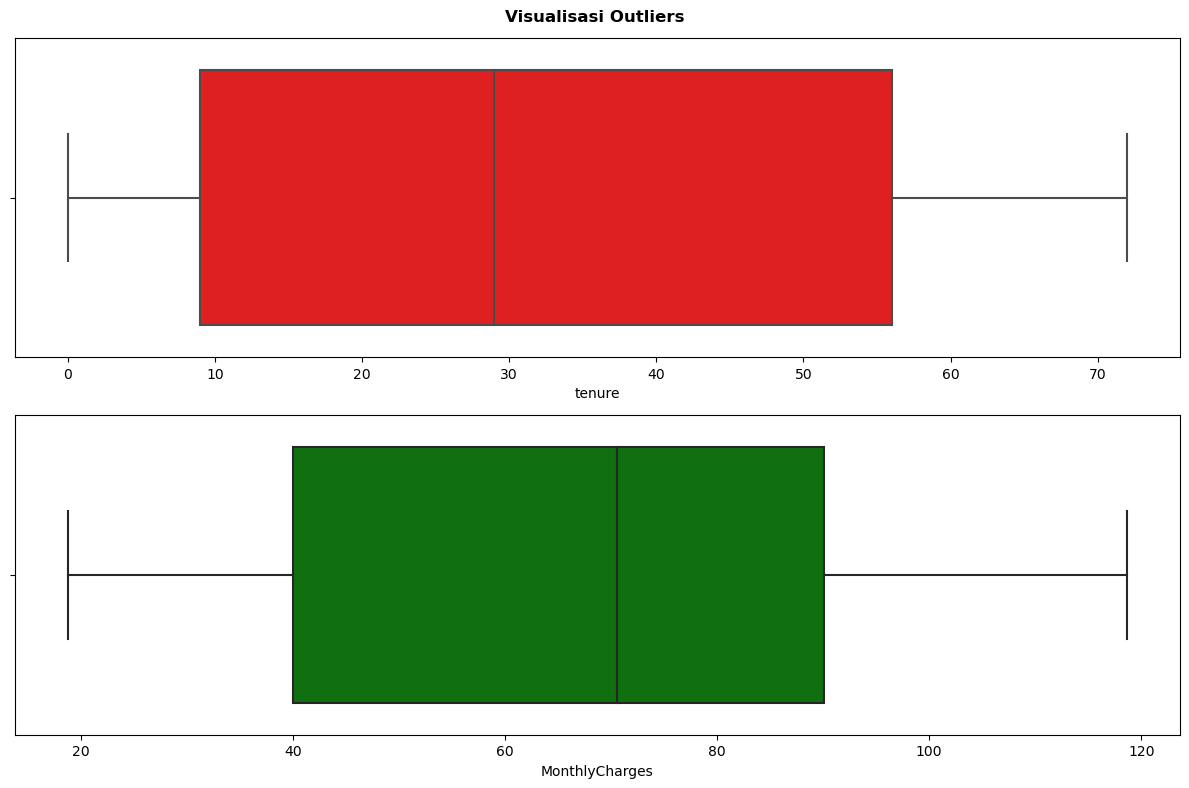

In [8]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
plt.suptitle('Visualisasi Outliers',fontweight='bold')
sns.boxplot(data=df,x='tenure',ax=ax[0],color='r')
sns.boxplot(data=df,x='MonthlyCharges',ax=ax[1],color='g')
plt.tight_layout()
plt.show()

* Dari boxplot di atas, kita tidak melihat adanya outlier pada kedua kolom.

## Data Analysis

### Cek Distribusi Dependent Variable (Target)

,proportion
Churn,
No,73.459716
Yes,26.540284


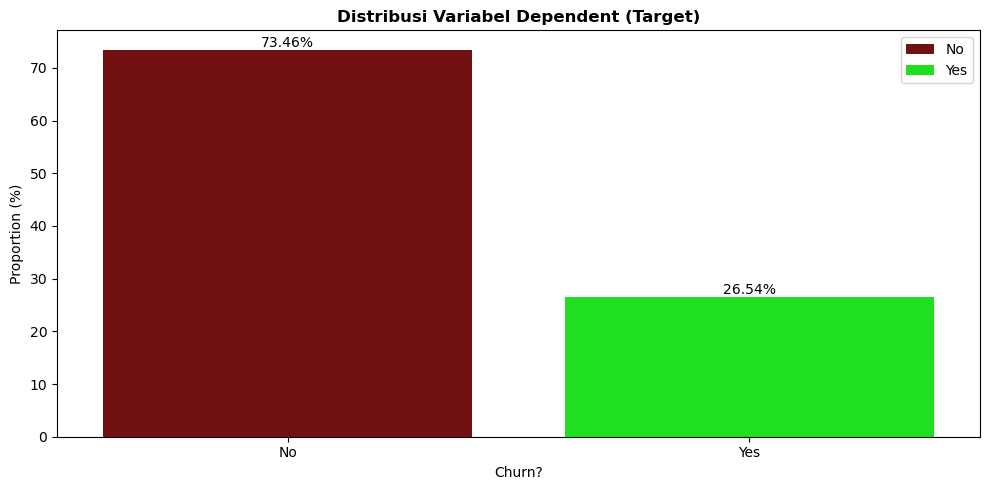

In [12]:
proporsi_target = (df['Churn'].value_counts(normalize=True)*100).to_frame()
display(proporsi_target)
plt.figure(figsize=(10,5))
target_bar = sns.barplot(x=proporsi_target.index,y=proporsi_target['proportion'],label=proporsi_target.index,palette=['maroon','lime'])
target_bar.bar_label(target_bar.containers[0],fmt='%.2f%%')
plt.title('Distribusi Variabel Dependent (Target)',fontweight='bold')
plt.xlabel('Churn?')
plt.ylabel('Proportion (%)')
plt.legend()
plt.tight_layout()
plt.show()

* Dari visualisasi di atas, kita bisa melihat perbedaan proporsi antara kedua kelas yang cukup jauh.
* Maka bisa disimpulkan, adanya class imbalance pada dataset kita.

In [9]:
# Encode Target Variabel untuk Memudahkan Visualisasi karena banyak kolom yang memiliki nilai diskrit sama dengan target.
df['Churn'] = df['Churn'].apply(lambda x:0 if x=='No' else 1)

### Berdasarkan Dependents

In [14]:
# Function untuk visualisasi kolom kategorikal
def cat_col_viz(col_name):
    display(pd.crosstab(df[col_name],df['Churn'],normalize='index')*100)
    sunburst = px.sunburst(df,path=[col_name,'Churn'],color='Churn',title=f'Distribusi Target Berdasarkan {col_name.capitalize()}')
    sunburst.show()

In [15]:
cat_col_viz('Dependents')

Churn,0,1
Dependents,,
No,68.52071,31.47929
Yes,84.79294,15.20706


* Kita bisa melihat ternyata mayoritas customer berasal dari kelompok yang tidak memiliki tanggungan, meski demikian justru kelompok tersebut yang memiliki jumlah terbanyak customer yang churn/berhenti berlangganan.
* Jika dilihat dari proporsinya, customer yang tidak memiliki tanggungan memiliki churn rate yang cukup tinggi yaitu 31%.Ini 2x lebih tinggi dibandingkan dengan kelompok customer yang memiliki tanggungan dimana hanya dikisaran 15%.

### Berdasarkan Tenure

In [16]:
# Function untuk visualisasi kolom numerikal
def num_col_viz(col_name):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    sns.histplot(data=df,x=col_name,hue='Churn',kde=True,ax=ax[0])
    tenure_bar = sns.barplot(data=df,x='Churn',y=col_name,errorbar=('ci',False),ax=ax[1])
    tenure_bar.bar_label(tenure_bar.containers[0],fmt='%.2f')
    ax[0].set_title(f'Distribusi {col_name.capitalize()} Berdasarkan Target',fontweight='bold')
    ax[1].set_title(f'Rata-rata {col_name.capitalize()} Berdasarkan Target',fontweight='bold')
    plt.tight_layout()
    plt.show()

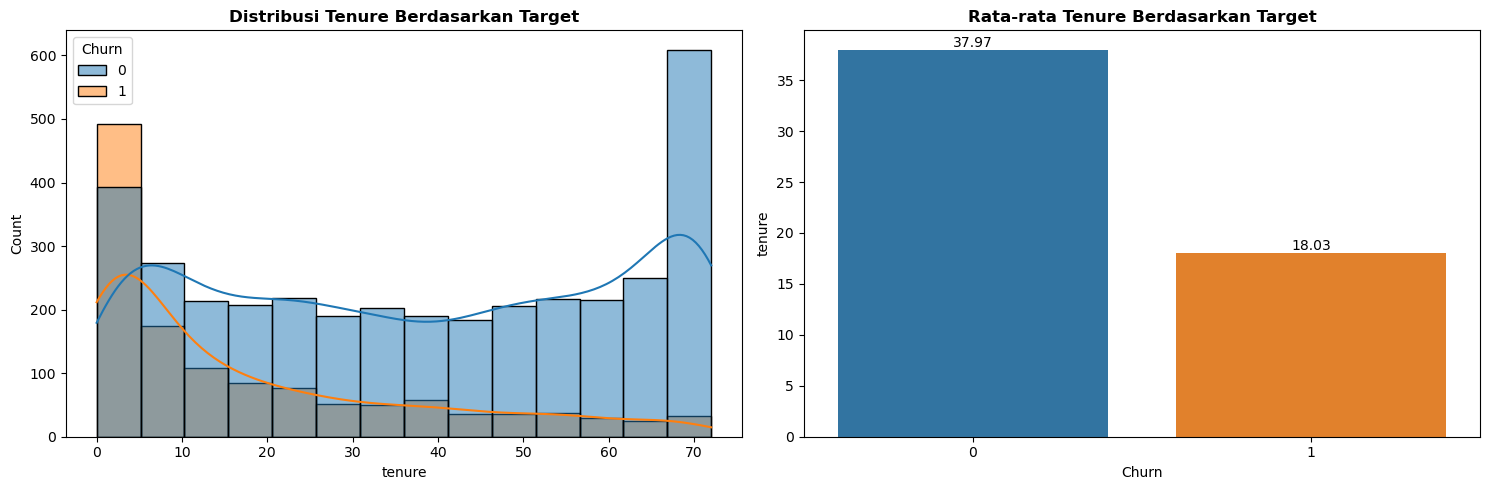

In [17]:
num_col_viz('tenure')

* Pada grafik histogram dan batang di atas, kita bisa melihat adanya kecenderungan dimana customer dengan tenure(jumlah bulan sejak pertama kali customer berlangganan jasa perusahaan) yang kecil atau bisa dikatakan customer yang masih tergolong baru lebih banyak memilih untuk berhenti berlangganan/churn.

### Berdasarkan Layanan Tambahan Online (OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport)

#### Berdasarkan OnlineSecurity

In [18]:
cat_col_viz('OnlineSecurity')

Churn,0,1
OnlineSecurity,,
No,58.636364,41.363636
No internet service,92.522433,7.477567
Yes,85.174825,14.825175


* Di sini kita melihat mayoritas customer tidak mengambil layanan tambahan untuk online security, dan customer yang churn kebanyakan berasal dari customer yang mengambil layanan internet tapi tidak menggunakan online security.

#### Berdasarkan OnlineBackup

In [19]:
cat_col_viz('OnlineBackup')

Churn,0,1
OnlineBackup,,
No,59.776536,40.223464
No internet service,92.522433,7.477567
Yes,79.494712,20.505288


* Di sini kita melihat mayoritas customer tidak mengambil layanan tambahan untuk online backup, dan customer yang churn kebanyakan berasal dari customer yang mengambil layanan internet tapi tidak menggunakan online backup.

#### Berdasarkan DeviceProtection

In [20]:
cat_col_viz('DeviceProtection')

Churn,0,1
DeviceProtection,,
No,61.609621,38.390379
No internet service,92.522433,7.477567
Yes,77.310427,22.689573


* Sama seperti sebelumnya, di sini terlihat juga customer yang mengambil layanan internet tapi tidak mengambil layanan device protection memiliki churn rate yang lebih tinggi dibanding yang mengambil.

#### Berdasarkan TechSupport

In [21]:
cat_col_viz('TechSupport')

Churn,0,1
TechSupport,,
No,59.090909,40.909091
No internet service,92.522433,7.477567
Yes,84.801136,15.198864


* Di sini juga sama, customer yang mengambil layanan internet tapi tidak mengambil layanan techsupport memiliki churn rate yang lebih tinggi dibanding yang mengambil ataupun yang tidak mengambil layanan internet.

### Berdasarkan InternetService

In [22]:
cat_col_viz('InternetService')

Churn,0,1
InternetService,,
DSL,81.662736,18.337264
Fiber optic,58.124420,41.875580
No,92.522433,7.477567


* Layanan internet yang paling diminati adalah tipe layanan fiber optic.Namun pelanggan yang menggunakan fiber optic justru memiliki churn rate paling tinggi dibanding layanan DSL ataupun yang tidak mengambil layanan internet.
* Kita akan coba telusuri lebih lanjut.

In [23]:
for col in 'OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport'.split(','):
    ct = pd.crosstab([df['InternetService'],df[col]],df['Churn'])
    ct['Total'] = ct.sum(axis=1)
    ct['proporsi_0 (%)'] = ct[0]/ct['Total']*100
    ct['proporsi_1 (%)'] = ct[1]/ct['Total']*100
    display(ct)

Churn                                  0    1  Total  proporsi_0 (%)  \
InternetService OnlineSecurity                                         
DSL             No                   626  230    856       73.130841   
                Yes                  759   81    840       90.357143   
Fiber optic     No                   793  771   1564       50.703325   
                Yes                  459  131    590       77.796610   
No              No internet service  928   75   1003       92.522433   

Churn                                proporsi_1 (%)  
InternetService OnlineSecurity                       
DSL             No                        26.869159  
                Yes                        9.642857  
Fiber optic     No                        49.296675  
                Yes                       22.203390  
No              No internet service        7.477567

Churn                                  0    1  Total  proporsi_0 (%)  \
InternetService OnlineBackup                                           
DSL             No                   689  233    922       74.728850   
                Yes                  696   78    774       89.922481   
Fiber optic     No                   595  631   1226       48.531811   
                Yes                  657  271    928       70.797414   
No              No internet service  928   75   1003       92.522433   

Churn                                proporsi_1 (%)  
InternetService OnlineBackup                         
DSL             No                        25.271150  
                Yes                       10.077519  
Fiber optic     No                        51.468189  
                Yes                       29.202586  
No              No internet service        7.477567

Churn                                  0    1  Total  proporsi_0 (%)  \
InternetService DeviceProtection                                       
DSL             No                   717  230    947       75.712777   
                Yes                  668   81    749       89.185581   
Fiber optic     No                   615  600   1215       50.617284   
                Yes                  637  302    939       67.838126   
No              No internet service  928   75   1003       92.522433   

Churn                                proporsi_1 (%)  
InternetService DeviceProtection                     
DSL             No                        24.287223  
                Yes                       10.814419  
Fiber optic     No                        49.382716  
                Yes                       32.161874  
No              No internet service        7.477567

Churn                                  0    1  Total  proporsi_0 (%)  \
InternetService TechSupport                                            
DSL             No                   643  231    874       73.569794   
                Yes                  742   80    822       90.267640   
Fiber optic     No                   800  768   1568       51.020408   
                Yes                  452  134    586       77.133106   
No              No internet service  928   75   1003       92.522433   

Churn                                proporsi_1 (%)  
InternetService TechSupport                          
DSL             No                        26.430206  
                Yes                        9.732360  
Fiber optic     No                        48.979592  
                Yes                       22.866894  
No              No internet service        7.477567

* Dari tabel di atas, kita bisa melihat ternyata customer yang mengambil layanan internet baik DSL maupun fiber optic jika tidak diikuti dengan mengambil layanan tambahan onlinenya yaitu OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport memiliki jumlah churn yang terbilang tinggi.
* Jika kita lihat proporsinya, layanan fiber optic tanpa mengambil layanan tambahan memiliki churn rate yang sangat tinggi hampir menyentuh 50%, bahkan pada tabel online backup churn rate mencapai 51%.

### Berdasarkan Contract

In [24]:
cat_col_viz('Contract')

Churn,0,1
Contract,,
Month-to-month,56.848030,43.151970
One year,89.856459,10.143541
Two year,97.200350,2.799650


* Customer dengan durasi contract yang lebih sedikit memiliki proporsi churn yang lebih tinggi dibanding yang memiliki contract lama.Ini memang wajar, karena customer dengan contract lama pada umumnya tidak semudah itu untuk langsung churn.

### Berdasarkan PaperlessBilling

In [25]:
cat_col_viz('PaperlessBilling')

Churn,0,1
PaperlessBilling,,
No,83.558091,16.441909
Yes,66.803419,33.196581


* Mayoritas customer perusahaan telah menggunakan paperless billing / e-billing, namun customer yang menggunakan e-billing justru lebih banyak memilih churn dibanding yang tidak menggunakan e-billing.

### Berdasarkan MonthlyCharges

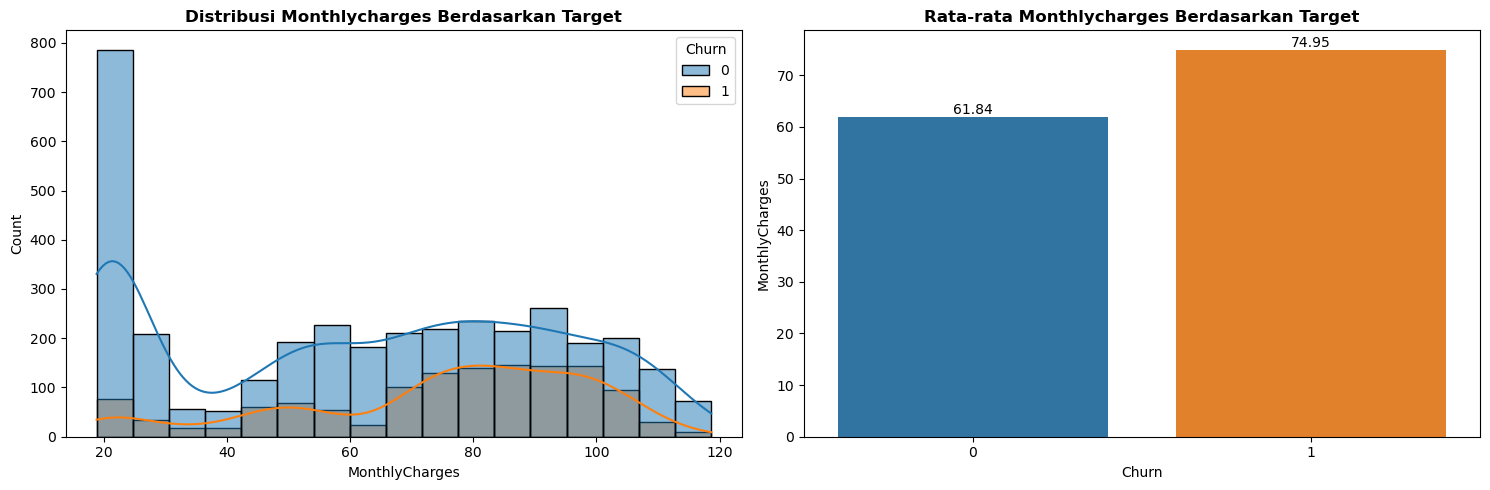

In [26]:
num_col_viz('MonthlyCharges')

* Di sini kita melihat customer yang churn cenderung memiliki monthly charges / tagihan layanan per bulan yang lebih tinggi, sebaliknya customer dengan tagihan per bulan yang sedikit cenderung tidak memilih untuk churn.
* Dari hasil analisa internet service sebelumnya, kita menemukan bahwa layanan fiber optic memiliki churn rate paling tinggi, diikuti layanan DSL dan terakhir yang tidak mengambil layanan internet.Mari kita coba lihat hubungan layanan internet dengan tagihan per bulannya.

In [27]:
df.groupby('InternetService')['MonthlyCharges'].mean().to_frame()

,MonthlyCharges
InternetService,
DSL,58.183992
Fiber optic,91.518825
No,21.130459


* Ternyata memang layanan fiber optic memiliki tagihan per bulan yang paling tinggi, yang dimana pada analisa kita di atas monthly charge yang semakin tinggi maka semakin tinggi juga churn rate nya.

## Data Preparation

In [32]:
x = df.drop('Churn',axis=1)
y = df['Churn']

In [33]:
# Tes Distribusi
stat,pval = normaltest(df['tenure'])
if pval<=0.05:
    print('Distribusi tidak normal')
else:
    print('Distribusi normal')


stat,pval = normaltest(df['MonthlyCharges'])
if pval<=0.05:
    print('Distribusi tidak normal')
else:
    print('Distribusi normal')

Distribusi tidak normal
Distribusi tidak normal


* Karena kolom numerikal kita tidak berdistribusi normal dan tidak memiliki outlier, maka scaler yang lebih cocok digunakan adalah MinMaxScaler.
* StandardScaler kurang cocok untuk digunakan pada data yang berdistribusi tidak normal.
Referensi:   
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler]

In [34]:
def nointernet_to_no(data):
    return data.replace('No internet service','No')


* Di sini saya mengubah nilai 'No Internet Service' menjadi 'No', karena memiliki arti yang sama yaitu sama-sama tidak menggunakan layanan tertentu.

In [35]:
# Membagi data menjadi train dan test set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

* Untuk membagi train dan test set saya menggunakan train_test_split dengan proporsi test size sebesar 20% dari data, di sini saya gunakan stratify agar pembagian class kita nantinya sesuai dengan proporsi yang telah kita tentukan yaitu 80% train dan 20% test.Dan pembagian data ini dilakukan secara acak dari parameter shuffle yang secara default adalah True.

In [36]:
one_hot_col = ['Dependents', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport',
       'PaperlessBilling']
ordinal_map = [{'col' : 'InternetService',
                'mapping' : {
                    'No' : 0,
                    'DSL' : 1,
                    'Fiber optic' : 2
                }},
                {'col' : 'Contract',
                 'mapping' : {
                     'Month-to-month' : 0,
                     'One year' : 1,
                     'Two year' : 2
    
                 }}]

transformer = ColumnTransformer(
    [
        ('one_hot',OneHotEncoder(drop='first'), one_hot_col),
        ('ordinal',ce.OrdinalEncoder(mapping=ordinal_map),['InternetService','Contract']),
        ('scaling',MinMaxScaler(),['tenure','MonthlyCharges'])
    ],
    remainder='passthrough'
)

* Di sini untuk kolom yang tidak memiliki urutan yang jelas seperti, Dependents, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, PaperlessBilling akan kita pakai OneHotEncoding.
* Pada OneHotEncoder kita menggunakan drop='first' agar kolom yang dihasilkan oleh OneHotEncoder nantinya dapat terhindar dari multicollinearity.
* Dan pada kolom yang memiliki urutan seperti kolom InternetService dan Contract kita gunakan OrdinalEncoding untuk mengubah nilainya menjadi berurutan.

Feature Selection tidak saya lakukan karena:
* Pada saat modeling akan dilakukan proses regularization(akan saya jelaskan lebih detail pada bagian hyperparameter tuning)
* Data yang kita gunakan memiliki jumlah feature yang tergolong sedikit.Sehingga tidak akan memakan waktu terlalu lama saat modeling.
* Kadang feature yang dibuang memiliki informasi yang berguna meskipun kecil sehingga dapat dimanfaatkan dengan regularization.

## Modeling & Evaluation

* Untuk experiment model saya akan selalu menggunakan stratified cross validation agar model yang dihasilkan lebih robust dan reliable untuk memprediksi data yang baru/belum terlihat pada saat training model(terhindar dari overfitting). Kali ini saya memilih menggunakan 10 fold stratified cross validation yang berguna untuk membagi data dengan menyamakan proporsi classnya pada tiap train dan validation setnya yang tidak dilakukan oleh cross validation biasa. Pilihan k nya saya lihat dari beberapa sumber salah satunya:[https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/#:~:text=For%20smaller%20datasets%2C%20use%20k,validation%20goals%20when%20choosing%20k.]

* Dataset ini memiliki y dengan value diskrit maka model yang digunakan hanya model untuk classification.

### Default Parameter Model 

In [28]:
# Models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
svc = SVC(random_state=42)

In [29]:
# Smotenc digunakan karena feature memiliki kolom kategorikal, jika menggunakan smote biasa akan terjadi error
smote = SMOTENC([col for col in x_train.columns if x_train[col].dtypes=='O'],random_state=42)
under = RandomUnderSampler(random_state=42)
over = RandomOverSampler(random_state=42)

In [42]:
cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def default_with_without_resampling(model,resampling_technique=None):
    
    '''Function untuk menampilkan recall score tiap model pada tiap cross validasi 
    dan menampilkan nilai rata-rata cross validasi dari tiap model.
    Params:
    - model:
        Model yang digunakan.
    - resampling_technique (Default:None):
        teknik resampling yang akan digunakan.None berarti tidak 
        memakai resampling dan data dibiarkan imbalance'''
    
    start_time = time.time()
    val_scores = {
        'Recall' : [],
        'Precision' : [],
        'F1' : [],
    }
    train_scores = {
        'Recall' : [],
        'Precision' : [],
        'F1' : [],
    }
    for train_index,val_index in cv.split(x_train,y_train):
        x_train_cv,y_train_cv= x_train.iloc[train_index],y_train.iloc[train_index]
        x_val_cv,y_val_cv = x_train.iloc[val_index],y_train.iloc[val_index]
        if resampling_technique != None :
            x_train_cv,y_train_cv = resampling_technique.fit_resample(x_train_cv,y_train_cv)
        estimator = Pipeline([
        ('nointernet_to_no',FunctionTransformer(nointernet_to_no)),
        ('preprocess',transformer),
        ('model',model)]
        )
        estimator.fit(x_train_cv,y_train_cv)
        y_pred_train = estimator.predict(x_train_cv)
        y_pred_val = estimator.predict(x_val_cv)
        for scorer,scorer_name in zip([recall_score,precision_score,f1_score],list(train_scores.keys())):
            train_scores[scorer_name].append(scorer(y_train_cv,y_pred_train))
            val_scores[scorer_name].append(scorer(y_val_cv,y_pred_val))
    for scorer_name in list(train_scores.keys()):
        train_scores[scorer_name]=np.mean(train_scores[scorer_name])
        val_scores[scorer_name]=np.mean(val_scores[scorer_name])
    train_score_df = pd.DataFrame(train_scores,index=['Train'])
    val_score_df = pd.DataFrame(val_scores,index=['Validation'])
    print(f'Runtime : {time.time()-start_time}')
    return pd.concat([train_score_df,val_score_df])


#### **Logistic Regression**

Logistic regression ini merupakan model/alat yang dapat digunakan untuk memprediksi hasil seperti yes atau no, kelompok ini biasa dipisah oleh sebuah batas yang berbentuk menyerupai huruf s yang merupakan function sigmoid.Alat ini membutuhkan data untuk menghasilkan prediksinya dan prediksi yang dihasilkan bergantung pada kualitas data dan relevansi data tersebut dengan tujuan penggunaan prediksi ini.Data yang dimaksud harus memiliki x dan y yang dimana x adalah faktor-faktor atau variabel relevan yang dapat digunakan untuk prediksi y yang merupakan target atau hal yang ingin diprediksi, struktur data ini dibutuhkan pada seluruh model yang termasuk dalam supervised learning.Karena dataset ini adalah kasus supervised learning maka model-model selanjutnya juga membutuhkan data dengan struktur yang sama(memiliki label).https://www.sciencedirect.com/science/article/abs/pii/S0169716116300517  
Agar mudah dimengerti, model ini bekerja dengan membagi hasil prediksi ke dalam kelompok yang yes atau no (https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Exam_pass_logistic_curve.svg/1200px-Exam_pass_logistic_curve.svg.png).Prediksi yang dihasilkan pada dasarnya berupa probabilitas, yang dimana digunakan threshold untuk mengubah probabilitas tersebut menjadi kelompok yes atau no, namun dalam capstone ini kita menggunakan library sklearn yang sudah secara otomatis menghasilkan prediksi 1 atau 0(yes or no), untuk mengakses probabilitas bisa menggunakan predict_proba.

In [43]:
print('Without Resampling')
display(default_with_without_resampling(lr)),
print('-'*50+'\nSmote')
display(default_with_without_resampling(lr,smote))
print('-'*50+'\nRandom Over Sampling')
display(default_with_without_resampling(lr,over))
print('-'*50+'\nRandom Under Sampling')
display(default_with_without_resampling(lr,under))

Without Resampling


Runtime : 1.2016997337341309


,Recall,Precision,F1
Train,0.518662,0.642603,0.574010
Validation,0.512621,0.638315,0.568048


--------------------------------------------------
Smote
Runtime : 6.147974729537964


,Recall,Precision,F1
Train,0.812958,0.746146,0.778106
Validation,0.787379,0.509470,0.618291


--------------------------------------------------
Random Over Sampling
Runtime : 1.110732078552246


,Recall,Precision,F1
Train,0.801270,0.744742,0.771958
Validation,0.793204,0.511638,0.621792


--------------------------------------------------
Random Under Sampling
Runtime : 1.0631060600280762


,Recall,Precision,F1
Train,0.801402,0.742111,0.770568
Validation,0.799029,0.510825,0.623078


* Untuk model Logistic Regression kita bisa melihat recall meningkat signifikan pada model yang menggunakan metode resampling baik over maupun under sampling, peningkatan recall memang biasany disertai dengan penurunan precision.Penurunan precision ini juga terbilang sedikit dibanding dengan peningkatan recallnya.
* Untuk Logistic Regression metode random under sampling memiliki recall paling baik, didukung dengan f1 score yang paling baik juga yang menghitung keselarasan tradeoff antara recall dan precision.
* Dari segi waktu metode randomundersampling juga memiliki waktu tercepat dibanding metode lainnya.

#### **Random Forest**

Sebelum masuk pada penjelasan random forest, kita harus mengerti konsep dari model decision tree terlebih dahulu karena random forest merupakan kumpulan dari beberapa decision tree.Decision Tree merupakan sebuah algoritma atau alat seperti logistic regression sebelumnya, namun dengan cara kerja yang berbeda.Decision Tree menghasilkan prediksi yes atau no berdasarkan kondisi tertentu seperti cara kerja if else, jelasnya bisa dilihat dari gambar ini https://miro.medium.com/v2/resize:fit:820/1*JAEY3KP7TU2Q6HN6LasMrw.png , jadi jika suatu kondisi terpenuhi maka prediksi kita akan diarahkan ke sebuah kondisi lagi, ini akan terus dilakukan sampai ditemukan tingkat impurity(proporsi prediksi yang masih memiliki campuran antara class yes dan no) yang diinginkan atau bisa juga ditentukan dengan parameter max_depth yang dapat membantu menentukan seberapa dalam/banyak cabang yang akan dihasilkan oleh decision tree.Di sini setelah kita tahu cara kerja decision tree, kita dapat lebih mudah mengerti cara kerja random forest.Jadi random forest merupakan ensemble model yang artinya terbentuk dari beberapa decision tree dengan metode bagging yang artinya tiap decision tree pada random forest akan dilatih menggunakan sample dataset yang random (bootstrapping) secara terpisah.Setelah itu hasil prediksi decision treenya akan dilakukan voting jika klasifikasi dan average jika regression untuk menghasilkan prediksi yang paling baik.[https://www.ibm.com/id-en/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,both%20classification%20and%20regression%20problems.]

In [44]:
print('Without Resampling')
display(default_with_without_resampling(rf)),
print('-'*50+'\nSmote')
display(default_with_without_resampling(rf,smote))
print('-'*50+'\nRandom Over Sampling')
display(default_with_without_resampling(rf,over))
print('-'*50+'\nRandom Under Sampling')
display(default_with_without_resampling(rf,under))

Without Resampling


Runtime : 9.841362714767456


,Recall,Precision,F1
Train,0.992665,0.992881,0.992770
Validation,0.460194,0.595178,0.517886


--------------------------------------------------
Smote
Runtime : 18.294530391693115


,Recall,Precision,F1
Train,0.999338,0.995537,0.997434
Validation,0.586408,0.534897,0.558915


--------------------------------------------------
Random Over Sampling
Runtime : 12.115061283111572


,Recall,Precision,F1
Train,0.999532,0.995345,0.997434
Validation,0.532039,0.564864,0.547154


--------------------------------------------------
Random Under Sampling
Runtime : 6.777117967605591


,Recall,Precision,F1
Train,0.99849,0.995808,0.997146
Validation,0.71165,0.492973,0.582141


* Untuk random forest juga memiliki recall paling tinggi menggunakan under sampling dengan peningkatan yang cukup signifikan dibanding metode resampling lainnya.
* Di sini undersampling juga lebih cepat dibanding metode lainnya.

#### **XGBoost**

XGBoost juga merupakan ensemble model dengan metode boosting yang berarti menggunakan beberapa model yang biasanya adalah decision tree untuk menghasilkan prediksi.Pada xgboost untuk menghasilkan prediksi yang baik diterapkan technique boosting dimana model weak learner yang biasanya memiliki performa kurang baik akan dilatih kembali dengan memberi perhatian khusus pada prediksi yang masih salah secara iterative, cont:DT_1,DT_2,DT_3,...,DT_n.Jadi cara kerjanya adalah pertama model akan melatih DT_1, model DT_1 ini akan disesuaikan bobotnya pada prediksi yang salah yang nantinya akan dilanjutkan untuk melatih DT_2 dengan bobot yang telah terupdate, proses ini dilakukan untuk mengurangi error yang dihasilkan/kesalahan prediksi yang dilakukan model sebelumnya, yang dimana menghasilkan kinerja overall yang lebih baik, singkatnya adalah model belajar dari kesalahan model sebelumnya.Ilustrasi gambar untuk metric logloss,mae,dsb yang bertujuan menurunkan error bukan precision,dkk[https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Gradient-boosting-LightGBM-vs-XGBoost.png?resize=591%2C431&ssl=1]  
Pada dasarnya xgboost ini menerapkan konsep yang serupa dengan model gradient boosting, tapi bedanya adalah xgboost menerapkan l1 dan l2 regularization yang membantu generalisasi.  
* XGBoost is a more regularized form of Gradient Boosting [ https://towardsdatascience.com/a-brief-introduction-to-xgboost-3eaee2e3e5d6 ]

In [45]:
print('Without Resampling')
display(default_with_without_resampling(xgb)),
print('-'*50+'\nSmote')
display(default_with_without_resampling(xgb,smote))
print('-'*50+'\nRandom Over Sampling')
display(default_with_without_resampling(xgb,over))
print('-'*50+'\nRandom Under Sampling')
display(default_with_without_resampling(xgb,under))

Without Resampling


Runtime : 2.819018602371216


,Recall,Precision,F1
Train,0.837648,0.883186,0.859783
Validation,0.497087,0.588725,0.538511


--------------------------------------------------
Smote
Runtime : 7.373777627944946


,Recall,Precision,F1
Train,0.965560,0.895884,0.929410
Validation,0.670874,0.524518,0.587932


--------------------------------------------------
Random Over Sampling
Runtime : 3.4360318183898926


,Recall,Precision,F1
Train,0.985235,0.914331,0.948455
Validation,0.643689,0.540193,0.587080


--------------------------------------------------
Random Under Sampling
Runtime : 2.4455974102020264


,Recall,Precision,F1
Train,0.982309,0.937230,0.959236
Validation,0.732039,0.473949,0.574835


* Xgboost juga paling baik menggunakan under sampling dengan recall paling tinggi.
* Runtime di sini juga dimenangkan oleh randomundersampling

#### LightGBM

* LightGBM menerapkan konsep yang hampir sama dengan xgboost, namun LightGBM menerapkan best-first (leaf-wise) growth dan xgboost menerapkan depth-first (level-wise) growth, maksud dari best-first (leaf-wise) growth adalah lightGBM dalam membagi/menumbuhkan cabang pada decision treenya itu cenderung melihat pada nodes/daun yang mengurangi loss/error terbesar dulu(vertikal), sedangkan depth-first (level-wise) growth membagi cabang langsung sesuai dengan kedalamannya sekaligus(horizontal).Perbedaan ini membuat best-first (leaf-wise) growth unggul dalam segi waktu training terutama pada dataset yang lebih besar dan dapat menghasilkan model yang lebih baik.  
Penjelasan dan ilustrasi gambar : [https://lightgbm.readthedocs.io/en/stable/Features.html#references]  

In [46]:
print('Without Resampling')
display(default_with_without_resampling(lgb)),
print('-'*50+'\nSmote')
display(default_with_without_resampling(lgb,smote))
print('-'*50+'\nRandom Over Sampling')
display(default_with_without_resampling(lgb,over))
print('-'*50+'\nRandom Under Sampling')
display(default_with_without_resampling(lgb,under))

Without Resampling


Runtime : 3.4240384101867676


,Recall,Precision,F1
Train,0.731499,0.821792,0.773997
Validation,0.495146,0.609768,0.546268


--------------------------------------------------
Smote
Runtime : 8.366207361221313


,Recall,Precision,F1
Train,0.930458,0.854133,0.890656
Validation,0.704854,0.523259,0.600076


--------------------------------------------------
Random Over Sampling
Runtime : 3.406048059463501


,Recall,Precision,F1
Train,0.958626,0.863527,0.908589
Validation,0.697087,0.532218,0.603133


--------------------------------------------------
Random Under Sampling
Runtime : 2.4845776557922363


,Recall,Precision,F1
Train,0.947573,0.883331,0.914294
Validation,0.755340,0.493431,0.596483


* LightGBM juga memiliki recall tertinggi dengan under sampling
* Runtime terbaik juga masih sama undersampling dibanding metode resampling yang lain, dan berbeda sangat tipis dengan yang tanpa resampling

#### **SVC**

SVC bekerja dengan menemukan decision boundary yang memisahkan antara tiap target classnya(0 dan 1) berupa hyperplanes, hyperplanes ini adalah subspace dalam n-dimensional space, seperti dalam 2d space hyperplanes itu hyperplanesnya merupakan 1d yaitu sebuah garis.Jadi dalam 2d akan terdapat sangat banyak hyperplanes/garis yang dapat memisahkan antara class 0 dan 1.Jadi SVC bertugas untuk mencari tahu garis optimal yang dapat memisahkan target class dan yang memiliki margin(jarak antara garis pemisah dan titik terdekat) paling jauh pada data point kedua class dengan garis pemisahnya.
https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496

In [47]:
print('Without Resampling')
display(default_with_without_resampling(svc)),
print('-'*50+'\nSmote')
display(default_with_without_resampling(svc,smote))
print('-'*50+'\nRandom Over Sampling')
display(default_with_without_resampling(svc,over))
print('-'*50+'\nRandom Under Sampling')
display(default_with_without_resampling(svc,under))

Without Resampling
Runtime : 15.568084478378296


,Recall,Precision,F1
Train,0.450485,0.669928,0.53855
Validation,0.435922,0.658262,0.52388


--------------------------------------------------
Smote


Runtime : 34.74709677696228


,Recall,Precision,F1
Train,0.835164,0.763122,0.797478
Validation,0.766990,0.505721,0.608919


--------------------------------------------------
Random Over Sampling
Runtime : 28.399731874465942


,Recall,Precision,F1
Train,0.814829,0.751303,0.781667
Validation,0.775728,0.509436,0.614342


--------------------------------------------------
Random Under Sampling
Runtime : 4.571381092071533


,Recall,Precision,F1
Train,0.809061,0.745965,0.776137
Validation,0.801942,0.499879,0.615432


* SVC juga memiliki recall dan f1 score tertinggi dengan undersampling.
* SVC juga bekerja paling cepat menggunakan undersampling.

Dari experiment di atas sepertinya seluruh model kita memiliki kinerja paling baik baik dan waktu terbaik menggunakan random under sampling, maka dari itu untuk experiment selanjutnya kita akan tetap menggunakan random undersampling.
* Logistic Regression --> 0.799029
* RandomForest --> 0.71165
* XGBoost --> 0.732039
* LightGBM --> 0.755340
* SVC --> 0.801942
  
Dari seluruh default model yang telah kita coba, SVC memiliki performa yang paling tinggi dengan recall 80%.
Dari seluruh default model sepertinya ada beberapa model yang masih overfitting meskipun performanya telah meningkat jauh.

### HyperParameter Tuning

* Pada beberapa experiment tuning model-model di bawah akan ada hyperparameter regularization.Regularization adalah salah satu teknik yang digunakan untuk mencegah overfitting dan underfitting dan juga dapat meningkatkan performa model. Teknik ini bekerja dengan memberikan penalty atau mengurangi coeff/beta pada tiap feature dalam suatu model yang dengan kata lain mengurangi kompleksitas model yang mungkin saja terjadi karena jumlah feature yang banyak.Sehingga model tidak terlalu bias pada feature tertentu saja.[ https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning#:~:text=ProgramExplore%20Program-,What%20is%20Regularization%20in%20Machine%20Learning%3F,and%20prevent%20overfitting%20or%20underfitting. ]
* Bisa dilihat saya tidak melakukan feature selection sebelumnya karena efek regularization ini yang sudah saya jelaskan diatas, model jadi mampu menggunakan feature yang bahkan memiliki sedikit informasi tanpa menyebabkan model tersebut menjadi overfitting/terlalu kompleks [ https://towardsdatascience.com/understanding-regularization-in-machine-learning-5a0369ac73b9 ]

In [48]:
def grid_tuner(model,param,transformer=transformer): 
    estimator_tuning=Pipeline([
        ('undersampling',under),
        ('nointernet_to_no',FunctionTransformer(nointernet_to_no)),
        ('preprocessing',transformer),
        ('model',model)
    ])
    grid_cv=GridSearchCV(estimator=estimator_tuning,param_grid=param,scoring='recall',n_jobs=-1,cv=cv)
    grid_cv.fit(x_train,y_train)
    return grid_cv

#### **Logistic Regression**

* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
* https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning  
Menurut referensi di atas kita dapat melakukan tuning pada hyperparameter C dan solver, untuk penalty tidak dilakukan tuning karena hanya penalty l2(Regularization) yang dapat digunakan pada tiap solver.Jika dipaksakan akan menghasilkan error nan.Dokumentasi Logistic Regression [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html ]

In [49]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Default Hyperparameter :**
* C --> 1
* solver --> 'lbfgs'  
  
    
Di sini hyperparameter C digunakan untuk menentukan kekuatan l2 regularizationnya, dilihat dari dokumentasi yang disediakan sklearn angka ini dibuat terbalik, jadi semakin kecil value C semakin besar pula efek regularization nya.
Untuk solver, penjelasannya dapat dilihat di [https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions]

In [50]:
logit_param = {
    'model__C' : [10,1,0.1,0.01,0.001,0.0005,0.0001],
    'model__solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
}
lr_grid_cv = grid_tuner(lr,logit_param)
print(lr_grid_cv.best_score_)
print(lr_grid_cv.best_params_)

0.8786407766990291
{'model__C': 0.0001, 'model__solver': 'liblinear'}


* Dari hasil tuning sepertinya hyperparameter C yang lebih kecil menghasilkan performa lebih baik, mungkin bisa kita coba perkecil lagi jangkauan parameter C nya karena nilai C terbaik yang didapat adalah dari 0.0001 yang dimana adalah nilai terkecil pada pilihan parameter kita.

In [51]:
logit_param = {
    'model__C' : [0.0001,0.00001,0.000005,0.000001],
    'model__solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
}
lr_grid_cv = grid_tuner(lr,logit_param)
print(lr_grid_cv.best_score_)
print(lr_grid_cv.best_params_)

0.8912621359223302
{'model__C': 1e-05, 'model__solver': 'liblinear'}


* Di sini bisa kita lihat impact yang besar dari penggunaan regularization terhadap model kita.
* Setelah kita coba lagi, gridsearch menghasilkan model yang lebih baik lagi dengan C lebih kecil hingga 0.00001(lebih kecil = lebih besar untuk model ini seperti dokumentasi di atas), namun C di bawah nilai tersebut sudah tidak meningkatkan performa model.Maka dari itu, berdasarkan experiment tuning yang telah dilakukan nilai hyperparameter terbaik untuk model logistic regression kita pada dataset ini adalah C-->0.00001 dan solver-->liblinear.
* Pada model, under sampling dan data split kita menggunakan random_state 42 jika random_state diubah atau proporsi split data ataupun kfold juga diubah maka hyperparameter terbaiknya juga akan berubah.
* Sebelum dilakukan hyperparameter tuning, model logistic regression menghasilkan recall score 0.799, kemudian setelah dilakukan tuning recall score meningkat pesat menjadi 0.891.Maka model terbaik untuk Logistic Regression adalah dengan tuning.

In [52]:
# Akses nilai coefficients tiap feature
lr_coeff = pd.DataFrame(
             {'Coefficient':lr_grid_cv.best_estimator_.named_steps.model.coef_[0]},
             index=lr_grid_cv.best_estimator_.named_steps.preprocessing.get_feature_names_out()
             )
lr_coeff

,Coefficient
one_hot__Dependents_Yes,-0.000853
one_hot__OnlineSecurity_Yes,-0.000873
one_hot__OnlineBackup_Yes,-0.000555
one_hot__DeviceProtection_Yes,-0.000425
one_hot__TechSupport_Yes,-0.000943
one_hot__PaperlessBilling_Yes,0.000962
ordinal__InternetService,0.002601
ordinal__Contract,-0.003717
scaling__tenure,-0.001423
scaling__MonthlyCharges,0.000577


* Dependents --> Rata-rata customer yang memiliki tanggungan memiliki probabilitas untuk churn yang lebih rendah sebesar 0.000853.
* OnlineSecurity --> Rata-rata customer yang mengambil layanan online security memiliki probabilitas untuk churn yang lebih rendah sebesar 0.000873.
* OnlineBackup --> Rata-rata customer yang mengambil layanan online backup memiliki probabilitas untuk churn yang lebih rendah sebesar 0.000555.
* DeviceProtection --> Rata-rata customer yang mengambil layanan device protection memiliki probabilitas untuk churn yang lebih rendah sebesar 0.000425.
* TechSupport --> Rata-rata customer yang mengambil layanan technical support memiliki probabilitas untuk churn yang lebih rendah sebesar 0.000943.
* PaperlessBilling --> Rata-rata customer yang menggunakan sistem tagihan elektronik memiliki probabilitas untuk churn yang lebih tinggi sebesar 0.000962.
* InternetService --> Probabilitas seorang customer untuk churn meningkat sebesar 0.002601 untuk tiap tingkatannya yaitu 'nointernet' ke 'DSL' atau 'DSL' ke 'FiberOptic'.
* Contract --> Probabilitas seorang customer untuk churn menurun sebesar 0.003717 untuk tiap tingkatan durasi contractnya yaitu 'month_to_month' ke 'one year' atau 'one year' ke 'two year'.
* tenure --> Rata-rata untuk tiap bulannya customer menggunakan layanan perusahaan maka probabilitas customer tersebut untuk churn berkurang sebesar 0.001423.
* MonthlyCharges --> Rata-rata untuk penambahan per USD(kita asumsikan dalam mata uang USD) pada jumlah tagihan bulanan seorang customer meningkatkan probabilitas customer tersebut untuk churn sebesar 0.000577.


#### **Random Forest**

https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/  
Dari referensi di atas kita dapat melakukan tuning pada beberapa hyperparameter:
* max_depth
* min_sample_split
* max_leaf_nodes
* min_samples_leaf
* n_estimators
* max_sample (bootstrap sample)
* max_features
<br>
Namun untuk tuning kali ini, kita akan menggunakan beberapa saja yaitu max_depth,max_features, dan n_estimators karena akan sangat memakan waktu jika kita tuning semuanya.

In [53]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

**Default Hyperparameter :**
Dokumentasi RandomForestClassifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* max_depth --> None(Menurut dokumentasinya None berarti model akan menambah node baru hingga tiap leafnya pure yang dimana cenderung akan overfitting)
* max_features --> sqrt  
* n_estimators --> 100
  
    
* max_depth digunakan untuk mengatur kedalaman tiap pohonnnya, dengan semakin dalam pohon dapat mengakibatkan overfitting.
* max_features digunakan untuk mengatur banyaknya jumlah features yang akan digunakan pada tiap pohonnya dan pemilihan featurenya secara random, sqrt berarti jumlah features yang digunakan = sqrt(n_features).
* n_estimators digunakan untuk mengatur seberapa banyak pohon yang digunakan dalam model random forest ini.

In [54]:
rf_param = {
    'model__max_depth' : [1,3,5],
    'model__max_features' :['sqrt', 'log2', None],
    'model__n_estimators' : [50,100,150]

}
rf_grid_cv = grid_tuner(rf,rf_param)
print(rf_grid_cv.best_score_)
print(rf_grid_cv.best_params_)

0.8922330097087381
{'model__max_depth': 1, 'model__max_features': None, 'model__n_estimators': 50}


* Dari hasil tuning sepertinya n_estimators masih bisa kita coba dengan value yang lebih kecil lagi.
* Dan max_depth akan dicoba dengan value yang lebih besar.

In [55]:
rf_param = {
    'model__max_depth' : [1,6,10],
    'model__max_features' :['sqrt', 'log2', None],
    'model__n_estimators' : [1,25,50]
}
rf_grid_cv = grid_tuner(rf,rf_param)
print(rf_grid_cv.best_score_)
print(rf_grid_cv.best_params_)

0.8922330097087381
{'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__n_estimators': 1}


* Ternyata n_estimators = 1 tetap memberikan hasil recall score yang sama dan max_depth terbaik masih 1, namun max_features yang sebelumnya None menjadi sqrt lagi yang merupakan nilai defaultnya.
* n_estimators yang lebih kecil tentunya mempercepat waktu model karena model decision tree yang dibuat lebih sedikit, maka n_estimators yang kita gunakan adalah 1.
* Dari hasil tuning kita sepertinya data kita tidak memerlukan model yang kompleks karena n_estimators=1 berarti model hanya menggunakan 1 decision tree, tapi ini masih asumsi saja.

In [56]:
def feature_importance(grid_cv):
    steps = grid_cv.best_estimator_.named_steps
    importance = pd.Series(steps.model.feature_importances_,steps.preprocessing.get_feature_names_out()).sort_values(ascending=False)
    return importance.plot(kind='barh',title='Feature Importance')

<Axes: title={'center': 'Feature Importance'}>

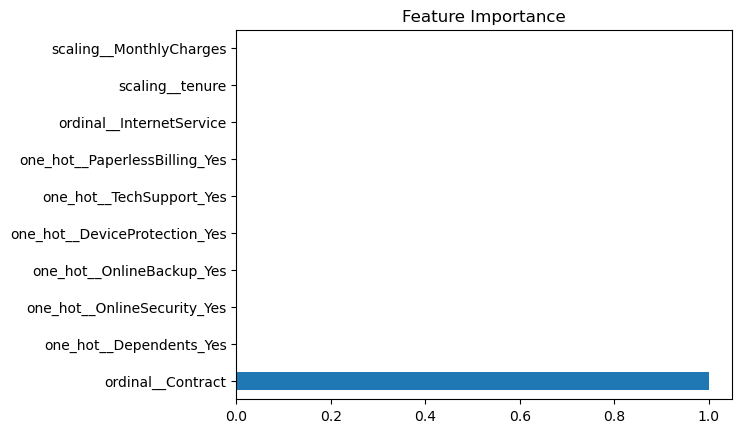

In [57]:
feature_importance(rf_grid_cv)

* Ternyata prediksi random forest hanya menggunakan 1 feature yaitu Contract ini terjadi karena max_depth terbaik kita adalah 1.Meski hanya menggunakan 1 feature, random forest mampu mengungguli model logistic regression untuk recall scorenya.
* Dilihat dari feature importancenya, untuk sekarang kita bisa menghilangkan feature lainnya saja.Ke depannya dengan tambahan data baru, mungkin saja feature importance nya akan berbeda.Untuk sekarang penghapusan feature saya lakukan hanya untuk model randomforest saja.

In [58]:
rf_transformer = ColumnTransformer(
    [
        ('ordinal',ce.OrdinalEncoder(mapping=[ordinal_map[1]]),['Contract'])
    ]
)

remainder saya gunakan value default yaitu drop agar feature tersisa hanya contract saja.

In [59]:
rf_param = {
    'model__max_depth' : [1,3,5],
    'model__max_features' :['sqrt', 'log2', None],
    'model__n_estimators' : [1,25,50]
}
rf_grid_cv = grid_tuner(rf,rf_param,rf_transformer)
print(rf_grid_cv.best_score_)
print(rf_grid_cv.best_params_)
print(f'column :{rf_grid_cv.best_estimator_.named_steps.preprocessing.get_feature_names_out()}')

0.8922330097087381
{'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__n_estimators': 1}
column :['ordinal__Contract']


* Dengan hanya menggunakan feature contract, kita masih mendapatkan score yang sama dengan sebelumnya tapi dengan hanya menggunakan 1 feature tentunya akan mempercepat kerja model.

#### **XGBoost**

https://neptune.ai/blog/xgboost-vs-lightgbm
<br>
Berdasarkan referensi di atas kita dapat melakukan tuning pada beberapa hyperparameter yang dianggap penting seperti:
* n_estimators 
* max_depth 
* min_child_weight 
* learning_rate/ eta 
* gamma/ min_split_loss 
* colsample_bytree
* subsample

In [60]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

**Default Hyperparameter :**
* n_estimators --> None (Mengatur jumlah weak learner, semakin banyak model semakin lambat)
* max_depth --> None (Mengatur kompleksitas kedalaman pohon, value terlalu kecil berakibat underfitting sebaliknya terlalu besar overfitting)
* min_child_weight --> None (Berperan sebagai regularizer)
* learning_rate/ eta --> None (Mengatur seberapa besar atau cepat model mengupdate wight tiap training step, value yang terlalu tinggi bisa mengakibatkan model tidak converge)
* gamma/ min_split_loss --> None (Berperan sebagai regularizer)
* colsample_bytree --> None (Mengatur proporsi kolom yang dipakai pada tiap weak learner)
* subsample --> None (Mengatur proporsi data point yang dipakai pada tiap weak learner)

In [61]:
xgb_param = {
    'model__n_estimators': [50,100,None],
    'model__max_depth':[1,5,None],
    'model__learning_rate': [0.01,0.1,None],
    'model__min_child_weight': [1,5,None],
    'model__gamma': [0,10,None],
    'model__colsample_bytree': [0.6, 0.8, None],
    'model__subsample': [0.6, 0.8, None]
}
xgb_grid_cv = grid_tuner(xgb,xgb_param)
print(xgb_grid_cv.best_score_)
print(xgb_grid_cv.best_params_)

0.8922330097087381
{'model__colsample_bytree': 0.6, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 1, 'model__min_child_weight': 1, 'model__n_estimators': 50, 'model__subsample': 0.6}


* Hasilnya ternyata sama dengan random forest, jika dilihat pada referensi ini https://stackoverflow.com/questions/59355590/python-randomforestclassifier-and-xgbclassifier-have-exact-same-score ada kemungkinan data yang kita gunakan tidak memerlukan model kompleks

<Axes: title={'center': 'Feature Importance'}>

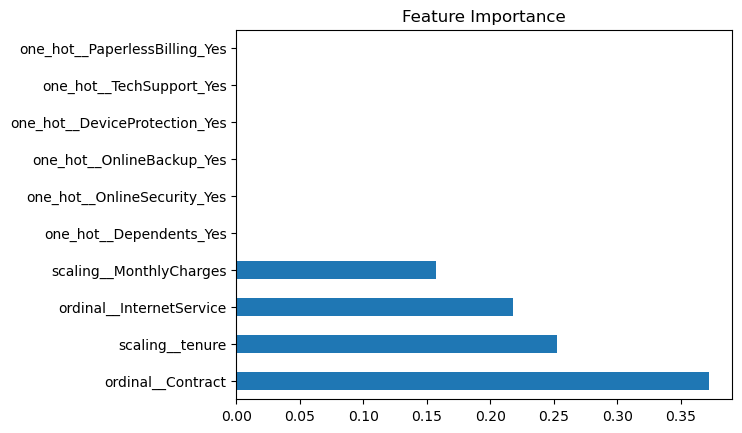

In [62]:
feature_importance(xgb_grid_cv)

* Untuk model XGBoost ternyata terdapat 4 feature yang penting, yang terpenting masih feature contract, kemudian tenure, internet service dan monthly charges. Dan untuk feature yang lainnya tidak informatif untuk model xgboost.

#### **LightGBM**

Berdasarkan https://neptune.ai/blog/lightgbm-parameters-guide, LightGBM memiliki banyak hyperparameter yang penting, kita akan memilih beberapa saja untuk tuning:
* max_depth - Memiliki guna yang sama dengan max_depth yang sebelumnya telah dijelaskan
* num_leaves - Untuk mengontrol kompleksitas dari model pohon(max jumlah daun).Menurut https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html nilai yang disarankan adalah nilai yang jauh lebih kecil dari 2^(max_depth), jika terlalu dekat atau lebih akan rentan overfitting.
* min_data_in_leaf - parameter yang sangat berguna untuk menghindari overfitting, nilai optimalnya dipengaruhi oleh banyaknya data kita dan num_leaves, nilai yang besar dapat mencegah model yang terlalu dalam/kompleks, namun ada kemungkinan underfitting.Menurut dokumentasinya untuk data yang besar nilai yang baik bisa ratusan atau ribuan.Karena data kita yang kecil, bisa kita coba dengan nilai yang kecil dulu.
* num_iterations - Mengatur banyaknya weak learner semakin banyak akan semakin rentan overfitting.
* learning_rate - Mengatur seberapa besar atau cepat model mengupdate wight tiap training step, value yang terlalu tinggi bisa mengakibatkan model tidak converge

In [63]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

**Default Hyperparameter :**
* max_depth –-> -1(Tidak memiliki limit)
* num_leaves –-> 31
* min_data_in_leaf –-> 20 (https://lightgbm.readthedocs.io/en/latest/Parameters.html)
* num_iterations --> 100 (https://lightgbm.readthedocs.io/en/latest/Parameters.html)
* learning_rate –-> 0.1

In [64]:
lgb_param = {
    'model__max_depth':[-1,5,10],
    'model__num_leaves': [2,3,4],
    'model__min_data_in_leaf': [0,5,20],
    'model__num_iterations': [25,50,100],
    'model__learning_rate': [0.05,0.01],
    
}
lgb_grid_cv = grid_tuner(lgb,lgb_param)
print(lgb_grid_cv.best_score_)
print(lgb_grid_cv.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
0.8922330097087381
{'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_data_in_leaf': 0, 'model__num_iterations': 25, 'model__num_leaves': 2}


c:\Users\Steven\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Dari hasil tuning, kita kembali mendapatkan hasil yang persis seperti xgboost dan random forest.

<Axes: title={'center': 'Feature Importance'}>

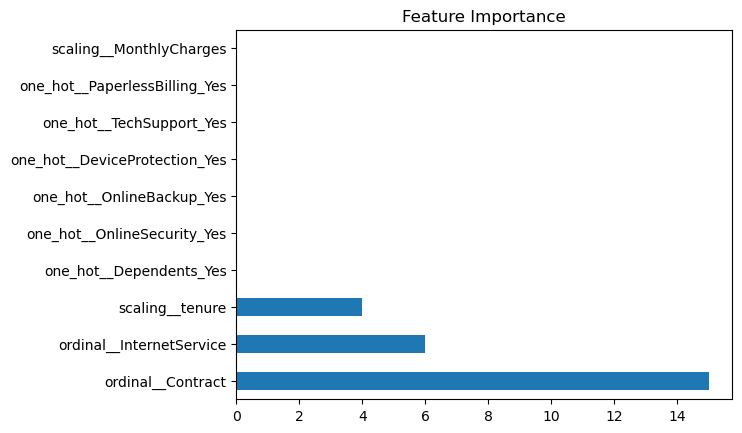

In [65]:
feature_importance(lgb_grid_cv)

* Terlihat masih feature contract yang paling penting pada model LGBM, diikuti internetservice dan tenure.

#### **Support Vector Classification**

* https://www.kaggle.com/code/rajeevnair676/svm-hyperparameter-tuning#Hyperparameter-Tuning-with-GridSearchCV
* https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
<br>
Dari kedua referensi di atas kita dapat coba melakukan tuning pada:
* C --> Mengatur kekuatan regularization dan dibuat terbalik, semakin kecil nilai maka semakin besar kekuatan nya
* Gamma --> Menentukan seberapa jauh jangkauan pengaruh tiap data point. gamma dengan value kecil berarti jaungkauan yang jauh dan sebaliknya [https://aqsa-qadir44.medium.com/tuning-parameters-of-svm-kernel-regularization-gamma-and-margin-5f2f6639121a#:~:text=The%20gamma%20parameter%20defines%20how,calculation%20for%20the%20seperation%20line.]
* Kernel --> function yang digunakan untuk melakukan transformasi pada data menjadi bentuk yang dibutuhkan. [https://data-flair.training/blogs/svm-kernel-functions/#:~:text=SVM%20Kernel%20Functions&text=The%20function%20of%20kernel%20is,(RBF)]

In [66]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

**Default Hyperparameter :**
* C –-> 1.0
* Gamma –-> scale
* kernel –-> rbf

In [67]:
svc_param = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'model__kernel': ['rbf','linear']
    }

svc_grid_cv = grid_tuner(svc,svc_param)
print(svc_grid_cv.best_score_)
print(svc_grid_cv.best_params_)

0.9543689320388349
{'model__C': 0.1, 'model__gamma': 0.001, 'model__kernel': 'rbf'}


* Setelah dilakukan tuning model SVC mengalami kenaikan yang signifikan dari recall sebelumnya 0.81(tanpa tuning) menjadi 0.95
* Untuk parameter C sepertinya bisa dicoba perkecil lagi.

In [68]:
svc_param = {
    'model__C': [0.01,0.1, 1, 10],
    'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'model__kernel': ['rbf','linear']
    }

svc_grid_cv = grid_tuner(svc,svc_param)
print(svc_grid_cv.best_score_)
print(svc_grid_cv.best_params_)

0.9543689320388349
{'model__C': 0.01, 'model__gamma': 0.001, 'model__kernel': 'rbf'}


* Ternyata setelah parameter C diperkecil recall yang dihasilkan masih tidak berubah.

* Karena kernel yang digunakan adalah rbf maka coefficient nya tidak dapat ditampilkan, karena coef_ hanya available untuk kernel linear  
[https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses]  
Weights assigned to the features when kernel="linear" - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Setelah dilakukan tuning semua model kita mengalami kenaikan signifikan pada recall scorenya.Maka model akhir kita akan menggunakan model yang sudah di tuning.

In [69]:
tuned_scores_df = pd.DataFrame(columns=['score'])
for gridcv_model,tuned_model_name in zip([lr_grid_cv,rf_grid_cv,xgb_grid_cv,lgb_grid_cv,svc_grid_cv],
                                        'Logistic Regression,Random Forest,XGBoost,LightGBM,Support Vector Machine Classifier'.split(',')):
    tuned_scores_df.loc[tuned_model_name] = gridcv_model.best_score_

tuned_scores_df

,score
Logistic Regression,0.891262
Random Forest,0.892233
XGBoost,0.892233
LightGBM,0.892233
Support Vector Machine Classifier,0.954369


Terlihat model dengan recall score terbaik adalah model SVC yang sudah di tuning yaitu 0.954369.Maka final model yang akan kita gunakan adalah model SVC yang sudah dituning.

## Conclusion & Recommendation

In [70]:
final_model = svc_grid_cv.best_estimator_
final_model.fit(x_train,y_train)
print(classification_report(y_test,final_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.51      0.66       713
           1       0.41      0.93      0.57       258

    accuracy                           0.62       971
   macro avg       0.68      0.72      0.61       971
weighted avg       0.81      0.62      0.64       971



Berdasarkan hasil classification report final model kita, kita dapat menyimpulkan jika nantinya kita menggunakan model ini kita dapat mengurangi retention cost (diskon,promo) yang dialokasikan untuk kurang lebih 51% dari total customer yang tidak churn, dan model kita dapat memprediksi hingga kurang lebih 93% dari total customer yang churn (semua ini berdasarkan recallnya)

Model kita memiliki ketepatan prediksi customer yang churn sebesar kurang lebih 41% (precision), jadi dari seluruh prediksi model yang memprediksi customer akan churn hanya terdapat kurang lebih 41%nya yang benar-benar churn. Masih ada customer yang sebenarnya tidak churn tapi diprediksi churn sekitar 49% dari total customer yang tidak churn.(recall)

Dengan menggunakan model kita tentunya kita dapat menyusun strategi yang lebih tepat untuk mengurangi jumlah customer yang akan churn.Dengan berkurangnya customer yang churn tentunya akan meningkatkan income perusahaan dan mengurangi loss akibat customer yang churn.Dengan jumlah customer churn yang berkurang tentunya akan mengurangi acquisition cost yang perlu dikeluarkan dimana biaya tersebut tergolong tinggi hingga 5x atau lebih dibanding retention cost. https://www.academia.edu/10217411/Do_Customer_Acquisition_Cost_Retention_and_Usage_Matter_to_Firm_Performance_and_Valuation.Jika dilihat perbandingannya, retention cost bukanlah concern utama dan retention cost yang dikeluarkan juga tentunya tidak akan terbuang sia-sia seperti diskon atau promo yang diberikan kepada customer yang tidak churn sebenarnya dapat mengurangi kemungkinan customer mempertimbangkan layanan dari perusahaan kompetitor, secara tidak langsung perusahaan juga memiliki kemungkinan memperoleh customer baru dari relasi customer tersebut yang tertarik dengan diskon atau promo yang ditawarkan.  
Dengan semakin banyaknya customer yang berhasil dipertahankan tentunya akan berpengaruh positif terhadap pertumbuhan perusahaan dan dengan semakin banyaknya customer yang dimiliki perusahaan dapat memberikan keunggulan pada brand kita dibanding kompetitor sehingga dalam mencari layanan telekomunikasi orang-orang akan pertama memikirkan brand kita.


#### Recommendation

* Bisa disediakan data customer lifetime value yang bisa digunakan untuk menyesuaikan prioritas ataupun menyesuaikan promo atau diskon yang diberikan.
* Mungkin dapat ditambahkan fitur-fitur baru seperti total penggunaan layanan(internet,telepon,tv,dll), daerah tempat tinggal, jumlah komplain, income customer,dll
* Dengan penambahan fitur dan sample kita dapat melakukan modeling ulang dan tuning ulang terutama pada model yang kompleks seperti xgboost, lightgbm yang mungkin dapat menghasilkan model yang lebih baik performanya secara overall.
* Layanan tambahan online dapat disediakan satu paket dengan layanan internet karena customer yang mengambil layanan internet tanpa layanan tambahan memiliki kemungkinan churn yang lebih tinggi.

In [412]:
!pip install dill

  Obtaining dependency information for dill from https://files.pythonhosted.org/packages/c9/7a/cef76fd8438a42f96db64ddaa85280485a9c395e7df3db8158cfec1eee34/dill-0.3.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------- ----------------------------- 30.7/116.3 kB 1.4 MB/s eta 0:00:01
   -------------------- ------------------ 61.4/116.3 kB 656.4 kB/s eta 0:00:01
   -------------------------------------- 116.3/116.3 kB 848.1 kB/s eta 0:00:00


In [71]:
import dill

* Di sini saya menggunakan dill yang merupakan library extension untuk pickle dan bukan menggunakan pickle karena dengan menggunakan pickle `FunctionTransformer(nointernet_to_no)` tidak dapat digunakan atau menimbulkan error. Function Transformer ini saya gunakan agar proses mengubah internet service menjadi no dapat dimasukkan ke pipeline model sehingga dapat di deploy.Jika tidak menggunakan function ini, kita perlu melakukan preprocess ini secara manual.Dengan menggunakan library dill saya bisa include function yang saya gunakan pada FunctionTransformer, sehingga dapat digunakan pada load model juga.

* Penggunaan dill juga sama seperti pickle, maka dari itu saya pertimbangkan untuk menggunakan dill. Mohon dimaklumin :(

In [72]:
final_model.fit(x,y)
filename = "D:\Purwadhika\Modul 3\Modul 3\Capstone Modul 3\Best_SVM_Model.sav"
dill.dump(final_model, open(filename , "wb"))

In [73]:
testing_model = dill.load(open(filename,'rb'))

In [74]:
testing_model.predict(x)

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [75]:
print(classification_report(y,testing_model.predict(x)))

              precision    recall  f1-score   support

           0       0.96      0.49      0.65      3565
           1       0.40      0.95      0.56      1288

    accuracy                           0.61      4853
   macro avg       0.68      0.72      0.61      4853
weighted avg       0.81      0.61      0.63      4853



**Terima Kasih**